In [57]:
!pip install swifter

In [58]:
import numpy as np
from sklearn import preprocessing
import os
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import swifter



# Utilities


In [59]:
# Function to check if a point is within any boundary box
def is_within_boundary_box(coords, box):
    min_latitude, min_longitude, max_latitude, max_longitude = box
    if (min_longitude < coords[1] < max_longitude and min_latitude < coords[0] < max_latitude):
      return True
    return False


# Function to check if a point is within any boundary box
def is_within_boundary_boxes(coords, boundary_boxes):
    for box in boundary_boxes:
        min_latitude, min_longitude, max_latitude, max_longitude = box
        if is_within_boundary_box(coords, box):
            return True
    return False

# Function to filter DataFrame based on boundary boxes
def filter_by_boundary_boxes(df, boundary_boxes):
  try:
    filtered_df = df[df.swifter.apply(lambda row: is_within_boundary_boxes((row['Latitude'], row['Longitude']), boundary_boxes), axis=1)]
    return filtered_df
  except:
    filtered_df = df[df.swifter.apply(lambda row: is_within_boundary_box((row['Latitude'], row['Longitude']), boundary_boxes), axis=1)]
    return filtered_df



def select_grid(file, boundary_boxes):
  emag_ds = pd.read_csv('/content/EMAG2v3onPredictorMesh.csv')

  for file in os.listdir('/content/'):
    if file.endswith('.nc'):
      print(file)
      predictor_xarray = xr.open_dataset(f'/content/{file}')

      try:
        predictor_data = np.array(predictor_xarray['z']).flatten()
      except:
        print('error')
      predictor_ds = pd.DataFrame({file[13:]: predictor_data})
      emag_ds = emag_ds.join(predictor_ds)

  # Save the filtered DataFrame to a CSV file
  filtered_emag = filter_by_boundary_boxes(emag_ds, boundary_boxes)
  return filtered_emag



def plot_on_selections(filtered_emag, boundary_boxes):
       for box in boundary_boxes:
          plotting_emag = filter_by_boundary_boxes(filtered_emag, box)
          plotting_emag = plotting_emag.reset_index(drop=True)

          grid_df = plotting_emag.pivot(index='Latitude', columns='Longitude', values = 'EMAG2v3' )

          # Step 3: Convert the pivoted DataFrame to an xarray.DataArray
          data_array = xr.DataArray(grid_df.values,
                                    coords=[grid_df.index, grid_df.columns],
                                    dims=['Latitude', 'Longitude'])


          try:
            data_array.plot(vmin = -200, vmax = 200)
            plt.title(f'Grid Data')
            plt.xlabel('Longitude')
            plt.ylabel('Latitude')
            plt.show()
          except:
            continue



# Benchmark Datasets
## Atlantic Region
Larger dataset to train and test via random selection.
## Atlantic Region Holes
Smaller dataset to test accuracy of the atlantic region trained model.
* Train and test a model on this dataset to see the difference in performance.






In [60]:
for file in os.listdir('/content/'):
  if file.endswith('.csv') and 'holes' in file:
    holes_grid = pd.read_csv(f'/content/{file}')
  elif file.endswith('.csv'):
    big_grid = pd.read_csv(f'/content/{file}')
  else:
    continue


# Define the main region (south, west, north, east)
region = [(36.993076, -109.045223, 41.0, -102.041524)]

# Define three non-intersecting bounding boxes of 1 degree by 1 degree within the region
holes = [
    (37.0, -108.0, 38.0, -107.0),  # Hole 1
    (38.5, -107.5, 39.5, -106.5),  # Hole 2
    (39.0, -106.0, 40.0, -105.0),  # Hole 3
    (40.5, -107.5, 41.5, -106.5),  # Hole 4
    (37.5, -105.5, 38.5, -104.5)   # Hole 5
]


Pandas Apply:   0%|          | 0/572 [00:00<?, ?it/s]

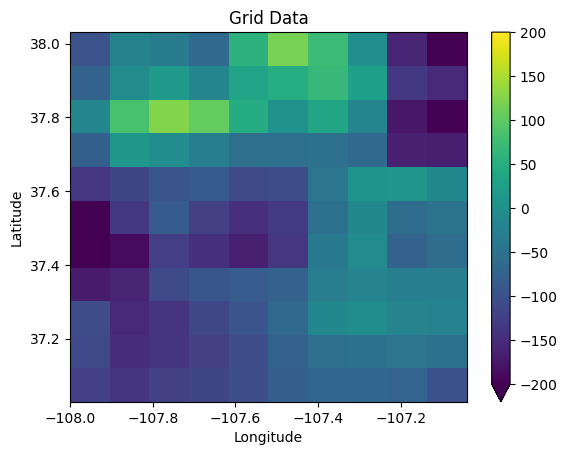

Pandas Apply:   0%|          | 0/572 [00:00<?, ?it/s]

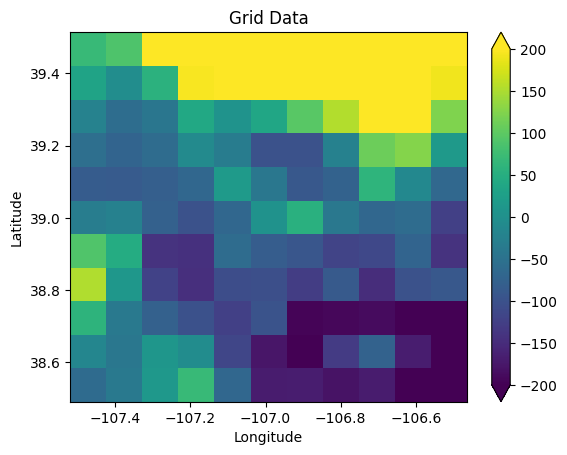

Pandas Apply:   0%|          | 0/572 [00:00<?, ?it/s]

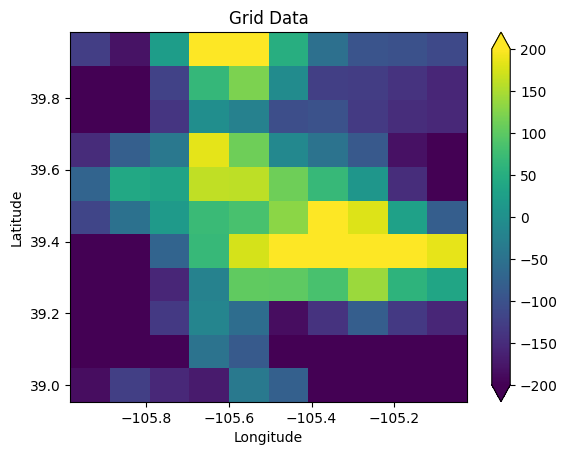

Pandas Apply:   0%|          | 0/572 [00:00<?, ?it/s]

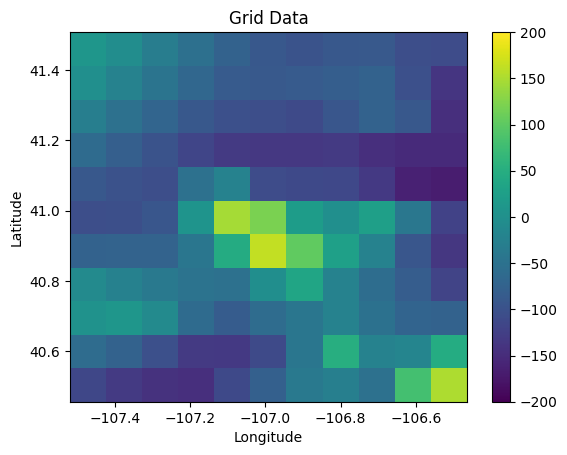

Pandas Apply:   0%|          | 0/572 [00:00<?, ?it/s]

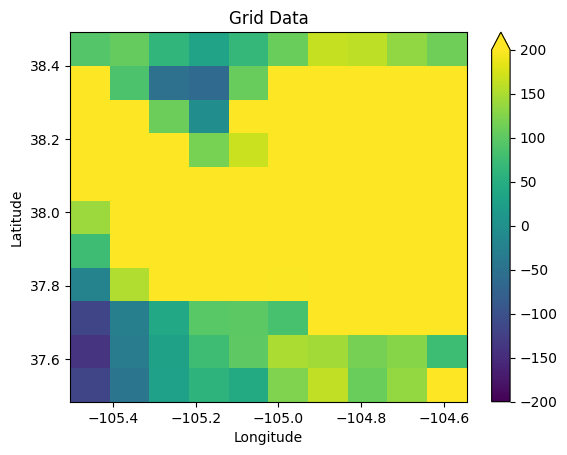

Pandas Apply:   0%|          | 0/2622 [00:00<?, ?it/s]

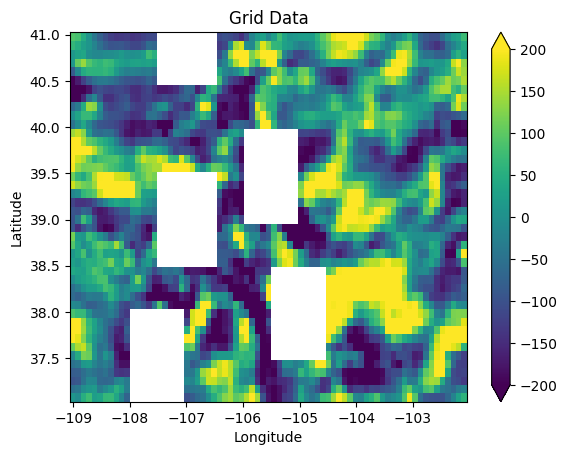

In [61]:
plot_on_selections(holes_grid, holes)
plot_on_selections(big_grid, region)

In [62]:
data = big_grid
data.head()

,Longitude,Latitude,EMAG2v3,3_gl_tot_sed_thick_,14_wgm2012_freeair_ponc_,10_sc_crust_vs_,16_sl_vgg_eot_,12_love_phase_,4_cm_curie_point_depth_,1_interpolated_mf7_,...,6_interpolated_bouguer_,18_igrf_inc_,9__igrf_dec_,15_rayleigh_phase_,5_gl_elevation_,7_sc_crust_vp_,11_love_group_,8_sc_crust_den_,13_rayleigh_group_,17_sc_crust_age_
0,-109.008,37.074554,8.885598,0.0,-30.756323,3654.5996,-30.450205,4.444029,14.152604,14.934673,...,-64.569302,63.873907,12.347408,3.981368,1486.9890,6363.401,4.054747,2801.3325,3.633127,NaN
1,-108.912,37.074554,-6.390570,0.0,-23.436403,3660.8977,-24.544447,4.443537,14.675679,8.364237,...,-64.319641,63.893822,12.312315,3.981209,1536.1307,6369.445,4.053580,2803.0544,3.632226,NaN
2,-108.816,37.074554,50.926330,0.0,-14.525378,3667.5212,-13.908217,4.443100,15.170097,1.376234,...,-63.087806,63.913715,12.277034,3.981152,1592.3435,6376.294,4.052704,2805.0151,3.631851,NaN
3,-108.720,37.074554,74.574806,0.0,-11.207472,3665.8916,-10.770667,4.442941,15.445264,-6.003865,...,-63.968989,63.933585,12.241564,3.981210,1637.2625,6374.455,4.052454,2804.4880,3.632161,NaN
4,-108.624,37.074554,23.319149,0.0,-5.318963,3668.6016,-5.472218,4.442962,15.718565,-13.742995,...,-80.025775,63.953433,12.205906,3.981370,1832.7362,6377.521,4.052587,2805.3690,3.633040,NaN


# Random Forest Regression
A basic random forest model where n estimators, regression trees, are randomly assigned subsets of data and predictors to use as splitting criteria, minimixing variance.

PCA (Principle Component Analysis) was experimented with but was ineffective. This is most likely due to random forest handling collinearity well. Collinearity is how PCA is able to reduce dimensions so intuitively not needed.

Standard training method of a scikit-learn estimator

In [63]:
data.columns


Index(['Longitude', 'Latitude', 'EMAG2v3', '3_gl_tot_sed_thick_',
       '14_wgm2012_freeair_ponc_', '10_sc_crust_vs_', '16_sl_vgg_eot_',
       '12_love_phase_', '4_cm_curie_point_depth_', '1_interpolated_mf7_',
       '2_interpolated_emm_', '6_interpolated_bouguer_', '18_igrf_inc_',
       '9__igrf_dec_', '15_rayleigh_phase_', '5_gl_elevation_',
       '7_sc_crust_vp_', '11_love_group_', '8_sc_crust_den_',
       '13_rayleigh_group_', '17_sc_crust_age_'],
      dtype='object')

In [56]:
# Columns to exclude
exclude_columns = ['EMAG2v3','2_interpolated_emm_']
include_columns = ['Longitude', 'Latitude']

for column in data.columns:
  if column in include_columns or column == 'EMAG2v3':
    continue
  try:
    if 0 < int(column[0:2]) and int(column[0:2]) <= 5: #select 5 highest ranked
      include_columns.append(column)
  except:
    if 0 < int(column[0]) and int(column[0]) <= 5: #select 5 highest ranked
      include_columns.append(column)
    continue

# Select columns not in exclude_columns using boolean indexing
X = data.loc[:, ~data.columns.isin(exclude_columns)]
X = data.loc[:, data.columns.isin(include_columns)]

X = X.fillna(X.median())

# Normalize the features
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)


y = data['EMAG2v3']

y = y.fillna(y.median())

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=102)

# Initialize Random Forest model
rf_model = RandomForestRegressor(n_estimators=300, random_state=42,oob_score=True)

# Train the model
rf_model.fit(X_train, y_train)

# Predict on test data
y_pred = rf_model.predict(X_test)





In [64]:
include_columns

['Longitude',
 'Latitude',
 '3_gl_tot_sed_thick_',
 '4_cm_curie_point_depth_',
 '1_interpolated_mf7_',
 '2_interpolated_emm_',
 '5_gl_elevation_']

# Model Evaluation

This section explains the key metrics used to evaluate the performance of a regression model.

In [65]:
def evaluate_model(y_test, y_pred,X):
  # Calculate Mean Squared Error (MSE)
  mse = mean_squared_error(y_test, y_pred)
  print(f"Mean Squared Error: {mse}")  # Measures the average squared difference between predicted and actual values

  # Calculate R-squared (R²)
  r2 = r2_score(y_test, y_pred)
  print(f"R² Score: {r2}")  # Represents the proportion of the variance in the dependent variable that is predictable from the independent variables

  # Calculate Root Mean Squared Error (RMSE)
  rmse = np.sqrt(mse)
  print(f"Root Mean Squared Error: {rmse}")  # Provides an absolute measure of fit by taking the square root of MSE

  # Calculate Mean Absolute Error (MAE)
  mae = mean_absolute_error(y_test, y_pred)
  print(f"Mean Absolute Error: {mae}")  # Measures the average magnitude of the errors in a set of predictions, without considering their direction

  # Calculate the standard deviation of the target variable in the test set
  std_dev = np.std(y_test)

  # Calculate Coefficient of Variation of RMSE (CV(RMSE))
  cv_rmse = rmse / std_dev
  print(f"Coefficient of Variation of RMSE: {cv_rmse}")  # Normalizes RMSE by dividing it by the standard deviation of the target variable

  #calculate the oob score
  oob_score = rf_model.oob_score_
  print(f"Out-of-bag Score: {oob_score}")

  print(f'Included Predictors:\n{include_columns}')

evaluate_model(y_test, y_pred,X)

Mean Squared Error: 3533.1887746144725
R² Score: 0.8069835933880691
Root Mean Squared Error: 59.44063235375674
Mean Absolute Error: 44.68384164629465
Coefficient of Variation of RMSE: 0.4393363251677818
Out-of-bag Score: 0.7992652499374663
Included Predictors:
['Longitude', 'Latitude', '3_gl_tot_sed_thick_', '4_cm_curie_point_depth_', '1_interpolated_mf7_', '2_interpolated_emm_', '5_gl_elevation_']


## Plotting Comparisons



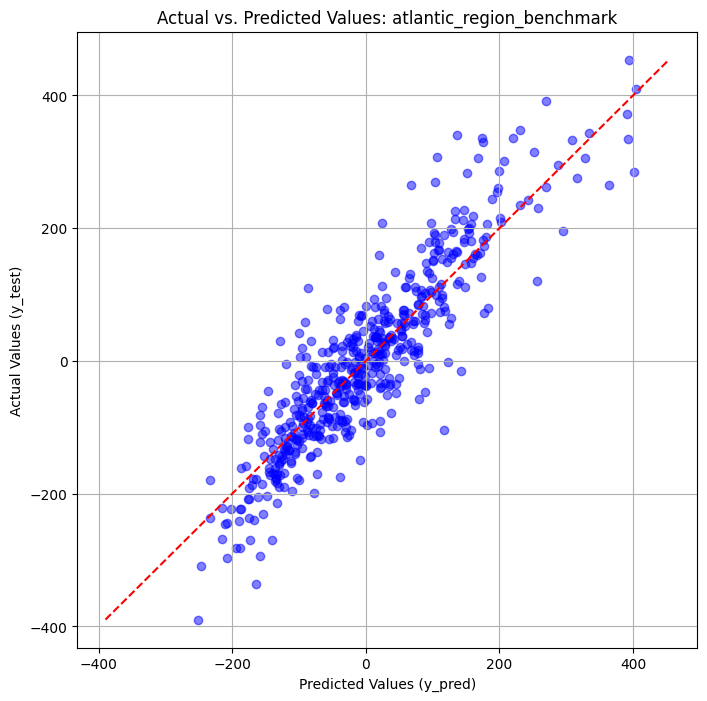

In [66]:

# Create a scatter plot
plt.figure(figsize=(8, 8))
plt.scatter(y_pred, y_test, alpha=0.5, color='b')
# Plot a line for perfect predictions
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='r', linestyle='--')

# Add labels and title
plt.xlabel('Predicted Values (y_pred)')
plt.ylabel('Actual Values (y_test)')
plt.title('Actual vs. Predicted Values: atlantic_region_benchmark')

# Show the plot
plt.grid(True)
plt.show()




---



# Outside/Inside Test Set Evaluation
Previous testing was on values within the trianing region. This section tests the model accuracy on data that is spatially within the training area, but not in the training set.


Results are also plotted against the true values of the training data, which is a less accurate measure of accuracy due to overfitting. The motivation of this plotting is to see how well the model captured spatial data in the region.

In [67]:
import xarray as xr
import matplotlib.pyplot as plt

plot_df = holes_grid
plot_df.head()

,Longitude,Latitude,EMAG2v3,3_gl_tot_sed_thick_,14_wgm2012_freeair_ponc_,10_sc_crust_vs_,16_sl_vgg_eot_,12_love_phase_,4_cm_curie_point_depth_,1_interpolated_mf7_,...,6_interpolated_bouguer_,18_igrf_inc_,9__igrf_dec_,15_rayleigh_phase_,5_gl_elevation_,7_sc_crust_vp_,11_love_group_,8_sc_crust_den_,13_rayleigh_group_,17_sc_crust_age_
0,-107.952,37.074554,-123.830179,0.0,-22.760447,3688.4130,-23.496560,4.449383,16.871244,-73.881720,...,-126.789150,64.091717,11.950970,3.986480,2035.3552,6401.4810,4.069077,2812.2925,3.669015,NaN
1,-107.856,37.074554,-137.767981,0.0,-46.667660,3684.8035,-45.173878,4.450588,16.849352,-82.414073,...,-129.501673,64.111375,11.913783,3.987425,1951.6422,6395.6865,4.072139,2810.5178,3.674970,NaN
2,-107.760,37.074554,-122.974076,0.0,-32.296944,3685.2678,-33.133564,4.451842,16.815730,-90.648821,...,-136.644912,64.131006,11.876403,3.988402,2090.0986,6395.0710,4.075195,2811.7847,3.680438,NaN
3,-107.664,37.074554,-117.192128,0.0,-36.537100,3690.8318,-37.212193,4.453820,16.772854,-98.483517,...,-134.130923,64.150613,11.838830,3.989940,2028.8525,6403.9560,4.079565,2812.9220,3.687133,NaN
4,-107.568,37.074554,-104.875664,0.0,-42.400963,3694.7130,-42.190125,4.455802,16.663847,-105.814616,...,-134.415233,64.170193,11.801062,3.991426,1995.5269,6404.3755,4.083659,2813.0440,3.691405,NaN


In [68]:

# Select columns not in exclude_columns using boolean indexing
X = plot_df.loc[:, ~plot_df.columns.isin(exclude_columns)]
X = plot_df.loc[:, plot_df.columns.isin(include_columns)]


X = X.fillna(X.median())

# Normalize the features
scaler = preprocessing.StandardScaler()
X = scaler.fit_transform(X)

# Predict on test data
y_pred = rf_model.predict(X)
y_test = plot_df['EMAG2v3'].fillna(plot_df['EMAG2v3'].median())
evaluate_model(y_test, y_pred,X)

outside_test_df = plot_df[['Longitude', 'Latitude']].copy()
outside_test_df['y_pred'] = y_pred
outside_test_df['y_test'] = y_test
outside_test_df

Mean Squared Error: 13365.16947519011
R² Score: 0.5954783070580122
Root Mean Squared Error: 115.60782618486566
Mean Absolute Error: 86.88733119624624
Coefficient of Variation of RMSE: 0.6360201985330244
Out-of-bag Score: 0.7992652499374663
Included Predictors:
['Longitude', 'Latitude', '3_gl_tot_sed_thick_', '4_cm_curie_point_depth_', '1_interpolated_mf7_', '2_interpolated_emm_', '5_gl_elevation_']


,Longitude,Latitude,y_pred,y_test
0,-107.952,37.074554,-57.141880,-123.830179
1,-107.856,37.074554,-45.885753,-137.767981
2,-107.760,37.074554,-51.837719,-122.974076
3,-107.664,37.074554,-52.318021,-117.192128
4,-107.568,37.074554,-30.811413,-104.875664
...,...,...,...,...
567,-106.896,41.459813,-75.337485,-97.647388
568,-106.800,41.459813,-69.614320,-91.276869
569,-106.704,41.459813,-85.326772,-89.845489
570,-106.608,41.459813,-118.028151,-105.614738


### Graphs Comparing Predicted Data to Actual Data

The plots below display both the model's predicted values (top plot) and the actual recorded values (bottom plot) for the same geographic region.

### Plot Attributes

- **Axes**: Longitude (x-axis) and Latitude (y-axis).
- **Color Scale**: Represents the magnitude of values.
  - **Predicted Data**: Ranges from approximately -300 to 100.
  - **Actual Data**: Ranges from approximately -400 to 400.
- **Colors**:
  - **Red**: Indicates higher values.
  - **Blue**: Indicates lower values.

### Analysis

- **Comparison**: Visually compare the spatial patterns and color distributions.
- **Ideal Outcome**: Predicted data should closely resemble actual data.
- **Discrepancies**: Highlight areas where the model's predictions differ from actual values, indicating the need for model adjustments or additional features.

These plots provide a quick visual assessment of the model's accuracy and highlight areas for potential improvement.

In [69]:
# Pivot the DataFrame
def dataframe_to_grid_plot(df):
  for hole in holes:
    outside_test_df = filter_by_boundary_boxes(df, hole)
    outside_test_df = outside_test_df.reset_index(drop=True)
    for result in ['y_pred','y_test']:

      pivot_df = outside_test_df.pivot(index='Latitude', columns='Longitude', values= result)

      data_array = xr.DataArray(pivot_df.values, coords=[pivot_df.index, pivot_df.columns],
                                            dims=['Latitude', 'Longitude'])
      data_array.plot(vmin = np.percentile(np.asarray(y_test),5), vmax = np.percentile(np.asarray(y_test),95), cmap='RdBu_r')
      plt.title(f'{result} values')
      plt.xlabel('Longitude')
      plt.ylabel('Latitude')
      plt.show()

Pandas Apply:   0%|          | 0/572 [00:00<?, ?it/s]

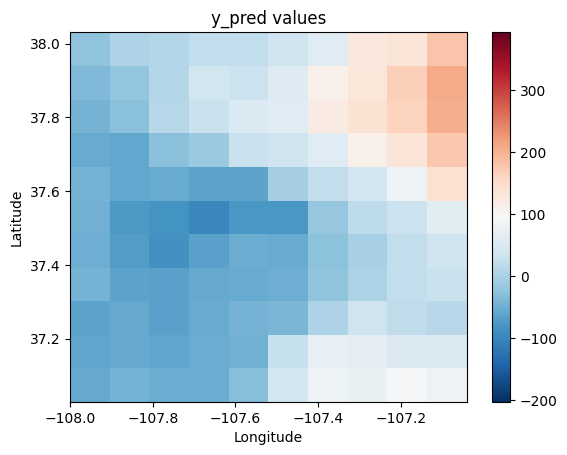

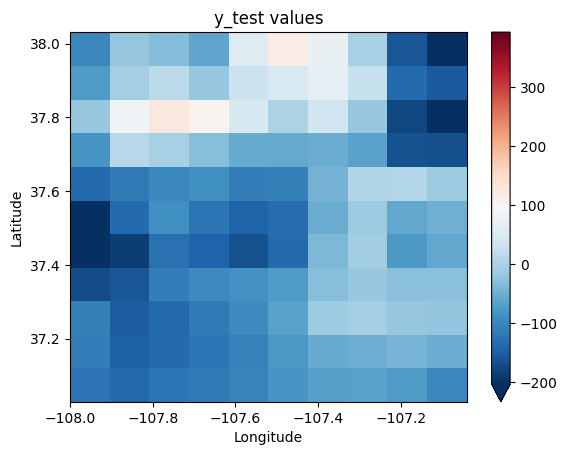

Pandas Apply:   0%|          | 0/572 [00:00<?, ?it/s]

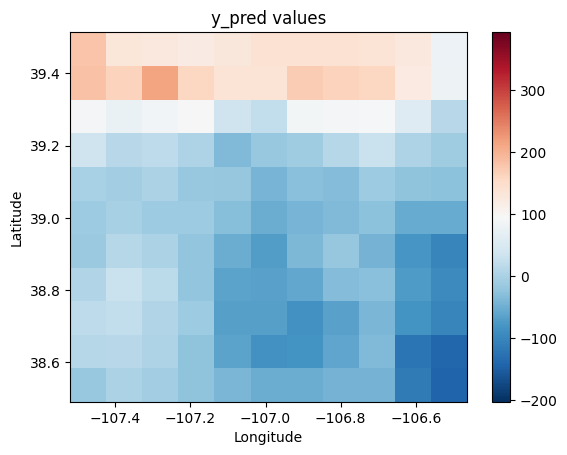

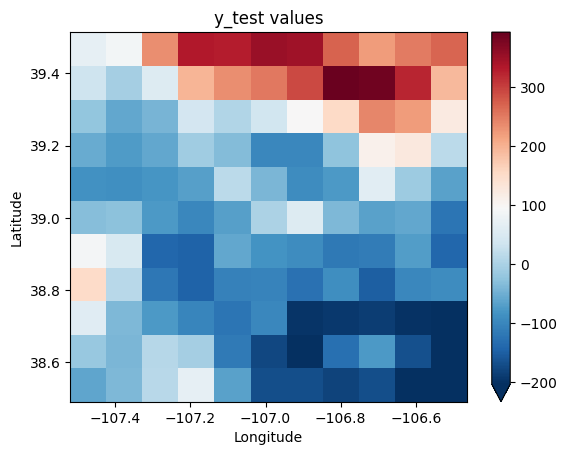

Pandas Apply:   0%|          | 0/572 [00:00<?, ?it/s]

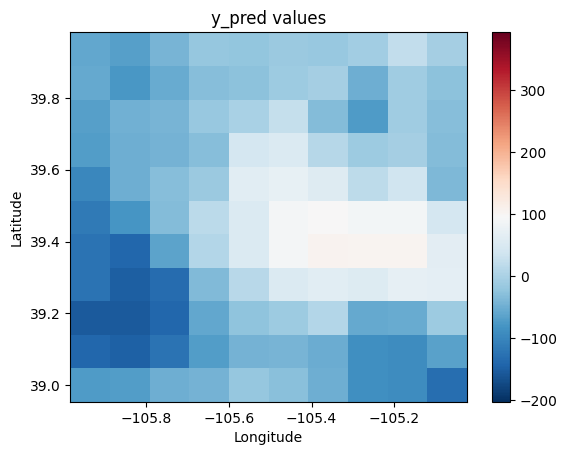

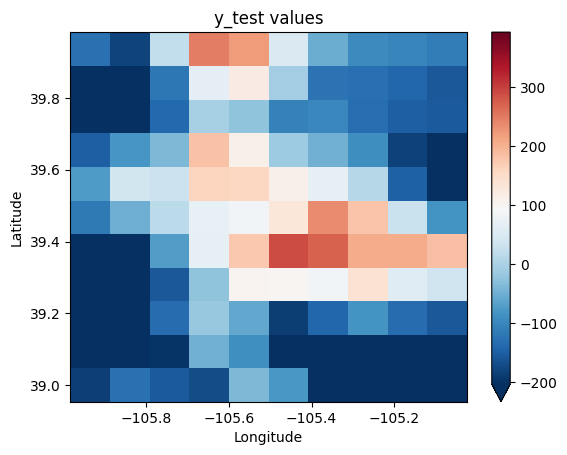

Pandas Apply:   0%|          | 0/572 [00:00<?, ?it/s]

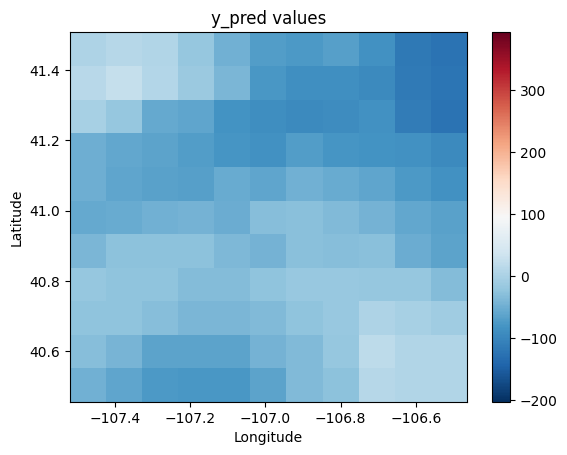

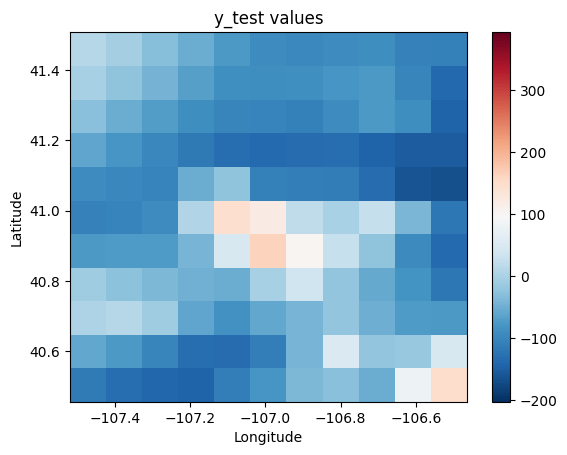

Pandas Apply:   0%|          | 0/572 [00:00<?, ?it/s]

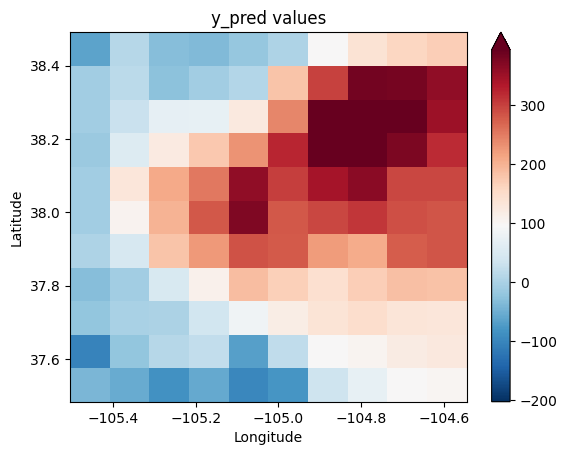

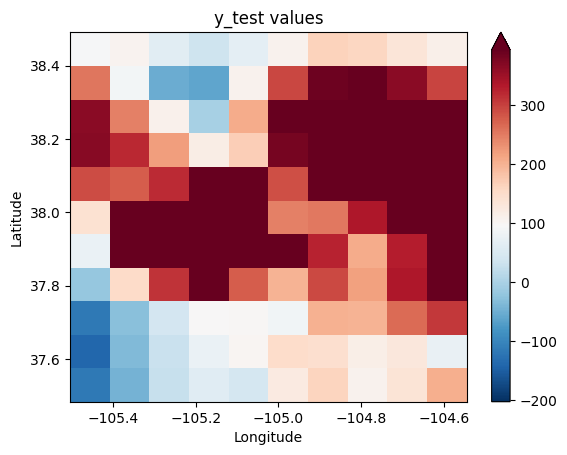

In [70]:
dataframe_to_grid_plot(outside_test_df)

# Feature Importances


Feature ranking:
Feature: 2_interpolated_emm_, Importance: 0.4869
Feature: Latitude, Importance: 0.1379
Feature: 4_cm_curie_point_depth_, Importance: 0.1171
Feature: 1_interpolated_mf7_, Importance: 0.1020
Feature: 5_gl_elevation_, Importance: 0.0865
Feature: Longitude, Importance: 0.0696
Feature: 3_gl_tot_sed_thick_, Importance: 0.0000


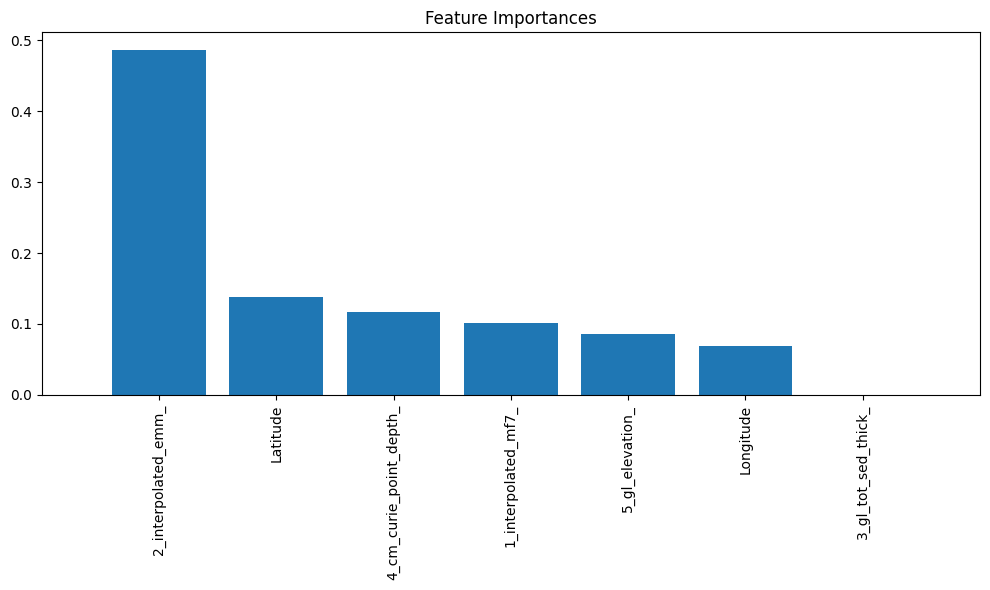

In [71]:
# Step 3: Extract and plot the feature importances
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = include_columns[:]
# Print the feature ranking with names
print("Feature ranking:")
for i in indices:
    print(f"Feature: {feature_names[i]}, Importance: {importances[i]:.4f}")

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(X.shape[1]), importances[indices], align="center")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()